<a href="https://colab.research.google.com/github/garynico/IndoBERT-Hoax/blob/main/IndoBERT_Hoax_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IndoBERT for Bahasa Indonesia Hoax News Detection

### Import library

In [1]:
# Drive
from google.colab import files
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
source_folder = '/content/drive/MyDrive/TASI/RandomSearch/DataImbalance'
destination_folder = '/content/drive/MyDrive/TASI/RandomSearch/ModelImbalance'

In [3]:
%cd //content/drive/MyDrive/TASI/RandomSearch/DataImbalance

/content/drive/MyDrive/TASI/RandomSearch/DataImbalance


In [4]:
!pip install transformers
!pip install keras.preprocessing
!pip install git+https://github.com/pytorch/text.git@v0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pytorch/text.git (to revision v0.10.0) to /tmp/pip-req-build-08z2c0ly
  Running command git clone --filter=blob:none --quiet https://github.com/pytorch/text.git /tmp/pip-req-build-08z2c0ly
  Running command git checkout -q 4da1de36247aa06622088e78508e0e38a4392e38
  Resolved h

In [5]:
import pandas as pd
import numpy as np
import torch


from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Preliminaries
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator


# Models
import torch.nn as nn

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

## Preliminaries

In [6]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

##Random Seed

In [8]:
import random

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # jika menggunakan multiple GPUs
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Model

In [9]:
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('Label', label_field), ('Tokenizing_Head', text_field), ('Tokenizing_Body', text_field)]

train, valid, test = TabularDataset.splits(path=source_folder, train='train3.csv', validation='valid3.csv', test='test3.csv',
                                           format='csv', fields=fields, skip_header=True)


In [10]:
# Iterators
train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.Tokenizing_Body),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.Tokenizing_Body),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

In [11]:
# Module
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "indobenchmark/indobert-base-p1"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    # def forward(self, headline, body, label=None):
    #     loss, text_fea = self.encoder(input_ids=body, attention_mask=(body!=PAD_INDEX), token_type_ids=(headline!=PAD_INDEX), labels=label)[:2]
    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [12]:
def save_checkpoint(save_path, model, valid_loss):
    if save_path is None:
        return

    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model):
    if load_path is None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, epoch_list):
    if save_path is None:
        return

    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'epoch_list': epoch_list}

    torch.save(state_dict, save_path)
    print(f'Metrics saved to ==> {save_path}')


def load_metrics(load_path):
    if load_path is None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Metrics loaded from <== {load_path}')

    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['epoch_list']

## Training and Validation

In [13]:
def train(model,
          optimizer,
          criterion=nn.BCELoss(),
          train_loader=train_iter,
          valid_loader=valid_iter,
          num_epochs=10,
          eval_every=1,
          file_path=destination_folder,
          best_valid_loss=float("Inf"),
          patience=3):

    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    epoch_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, title, text), _ in train_loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()

        # evaluation step
        if epoch % eval_every == 0:
            model.eval()
            with torch.no_grad():
                # validation loop
                for (labels, title, text), _ in valid_loader:
                    labels = labels.type(torch.LongTensor)
                    labels = labels.to(device)
                    text = text.type(torch.LongTensor)
                    text = text.to(device)
                    output = model(text, labels)
                    loss, _ = output

                    valid_running_loss += loss.item()

            # evaluation
            average_train_loss = running_loss / len(train_loader)
            average_valid_loss = valid_running_loss / len(valid_loader)
            train_loss_list.append(average_train_loss)
            valid_loss_list.append(average_valid_loss)
            epoch_list.append(epoch)

            # resetting running values
            running_loss = 0.0
            valid_running_loss = 0.0
            model.train()

            # print progress
            print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                  .format(epoch+1, num_epochs, average_train_loss, average_valid_loss))

            # checkpoint
            if best_valid_loss > average_valid_loss:
                best_valid_loss = average_valid_loss
                save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, epoch_list)

    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, epoch_list)
    print('Finished Training!')
    return train_loss_list, valid_loss_list, epoch_list, best_valid_loss

In [14]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train_loss_list, valid_loss_list, epoch_list, best_valid_loss = train(model=model, optimizer=optimizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6521, Valid Loss: 0.7228
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/10], Train Loss: 0.6210, Valid Loss: 0.6529
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/10], Train Loss: 0.2738, Valid Loss: 0.2941
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/10], Train Loss: 0.1369, Valid Loss: 0.2067
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [5/10], Train Loss: 0.0909, Valid Loss: 0.1357
Model saved to ==> /content/drive/MyDrive/TASI/

Metrics loaded from <== /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt


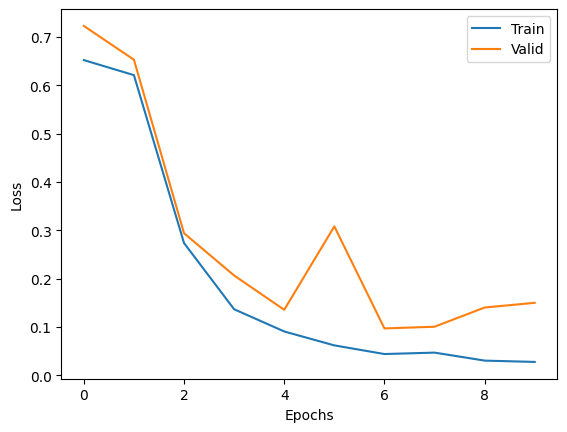

In [15]:
train_loss_list, valid_loss_list, epoch_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(epoch_list, train_loss_list, label='Train')
plt.plot(epoch_list, valid_loss_list, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from <== /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Classification Report:
Real - Precision: 0.8632, Recall: 0.9266, F1-Score: 0.8938
Fake - Precision: 0.9633, Recall: 0.9292, F1-Score: 0.9459
Accuracy: 0.9283582089552239


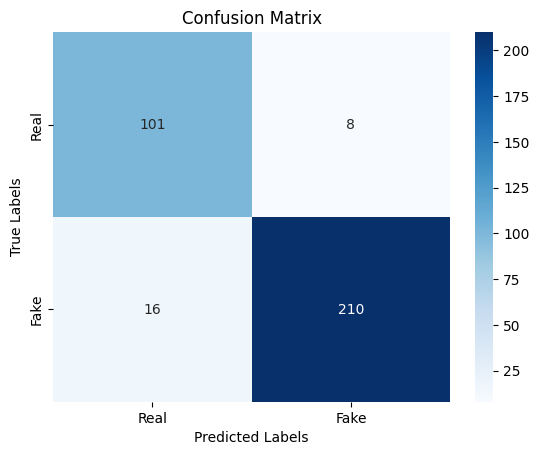

In [16]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text), _ in test_loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            output = model(text, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())

    # Mengganti label 1 menjadi "real" dan label 0 menjadi "fake"
    y_true = np.where(np.array(y_true) == 1, "real", "fake")
    y_pred = np.where(np.array(y_pred) == 1, "real", "fake")

    # Menghitung dan mencetak hasil precision, recall, f1-score, dan accuracy
    report = classification_report(y_true, y_pred, labels=["real", "fake"], digits=4, output_dict=True)
    print('Classification Report:')
    for label, scores in report.items():
        if label in ["real", "fake"]:
            precision = scores['precision']
            recall = scores['recall']
            f1_score = scores['f1-score']
            print(f"{label.capitalize()} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy}')

    # Menghitung dan mencetak confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Real', 'Fake'])
    ax.yaxis.set_ticklabels(['Real', 'Fake'])
    plt.show()

best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)

##Hyperparameter Tuning with Import Grid

In [17]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.1 MB/s eta 0:00:00


In [18]:
import optuna

# Define an objective function to optimize hyperparameters
def objective(trial):
    # Sample hyperparameters
    lr = trial.suggest_categorical('lr', [2e-5, 3e-5, 5e-5])
    num_epochs = trial.suggest_categorical('num_epochs', [5, 6, 7, 8, 9, 10])
    batch_size = trial.suggest_categorical('batch_size', [16, 32])

    # Define model, optimizer, and criterion
    model = BERT().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Train model
    train_loss_list, valid_loss_list, epoch_list, best_valid_loss = train(model=model,
                                                                          optimizer=optimizer,
                                                                          criterion=criterion,
                                                                          train_loader=train_iter,
                                                                          valid_loader=valid_iter,
                                                                          num_epochs=num_epochs,
                                                                          eval_every=1,
                                                                          file_path=destination_folder)

    # Save results
    key = f'lr={lr}, num_epochs={num_epochs}, batch_size={batch_size}'
    results[key] = {
        'train_loss': train_loss_list[-1],
        'valid_loss': valid_loss_list,
        'epoch_list': epoch_list,
        'best_valid_loss': best_valid_loss,
        'lr': lr,
        'num_epochs': num_epochs,
        'batch_size': batch_size,
    }

    # Save model if best
    if best_valid_loss < results.get('best_valid_loss', float('inf')):
        results['best_valid_loss'] = best_valid_loss
        results['best_model'] = key
        torch.save(model.state_dict(), f'{destination_folder}/model_{key}.pt')

    return best_valid_loss

# Set up Optuna study with RandomSampler
sampler = optuna.samplers.RandomSampler(seed=seed)
study = optuna.create_study(direction='minimize', sampler=sampler)

# Run optimization
results = {}
study.optimize(objective, n_trials=36)

# Print best model and hyperparameters
best_model = results['best_model']
best_hyperparams = results[best_model]
print('Best model:', best_model)
print('Best valid loss:', best_hyperparams['best_valid_loss'])

[I 2023-06-20 06:13:45,332] A new study created in memory with name: no-name-9a6f9ec3-e491-4305-9313-e99fb8d4a2b5
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.4816, Valid Loss: 0.3681
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/9], Train Loss: 0.2258, Valid Loss: 0.2334
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/9], Train Loss: 0.1561, Valid Loss: 0.1817
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/9], Train Loss: 0.0758, Valid Loss: 0.1827
Epoch [5/9], Train Loss: 0.0441, Valid Loss: 0.1285
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [6/9], Train Loss: 0.0364, Valid Loss: 0.1357


[I 2023-06-20 06:16:54,241] Trial 0 finished with value: 0.12848430427922203 and parameters: {'lr': 3e-05, 'num_epochs': 9, 'batch_size': 16}. Best is trial 0 with value: 0.12848430427922203.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6691, Valid Loss: 0.6541
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/8], Train Loss: 0.5685, Valid Loss: 0.4617
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/8], Train Loss: 0.2378, Valid Loss: 0.1763
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/8], Train Loss: 0.1588, Valid Loss: 0.2200
Epoch [5/8], Train Loss: 0.0823, Valid Loss: 0.2721
Epoch [6/8], Train Loss: 0.0448, Valid Loss: 0.1922
Epoch [7/8], Train Loss: 0.0196, Valid Loss: 0.4488


[I 2023-06-20 06:19:31,939] Trial 1 finished with value: 0.17633572087756225 and parameters: {'lr': 2e-05, 'num_epochs': 8, 'batch_size': 16}. Best is trial 0 with value: 0.12848430427922203.


Epoch [8/8], Train Loss: 0.0410, Valid Loss: 0.2003
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.5388, Valid Loss: 0.3162
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/5], Train Loss: 0.2241, Valid Loss: 0.1698
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/5], Train Loss: 0.1364, Valid Loss: 0.1923
Epoch [4/5], Train Loss: 0.0849, Valid Loss: 0.1918


[I 2023-06-20 06:21:14,230] Trial 2 finished with value: 0.16979740713057773 and parameters: {'lr': 5e-05, 'num_epochs': 5, 'batch_size': 16}. Best is trial 0 with value: 0.12848430427922203.


Epoch [5/5], Train Loss: 0.0693, Valid Loss: 0.2180
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6402, Valid Loss: 0.6259
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/7], Train Loss: 0.4235, Valid Loss: 0.3492
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/7], Train Loss: 0.2133, Valid Loss: 0.1698
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/7], Train Loss: 0.1501, Valid Loss: 0.2211
Epoch [5/7], Train Loss: 0.0655, Valid Loss: 0.1788
Epoch [6/7], Train Loss: 0.0247, Valid Loss: 0.1918


[I 2023-06-20 06:23:32,164] Trial 3 finished with value: 0.1698474217472332 and parameters: {'lr': 3e-05, 'num_epochs': 7, 'batch_size': 32}. Best is trial 0 with value: 0.12848430427922203.


Epoch [7/7], Train Loss: 0.0260, Valid Loss: 0.3150
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6746, Valid Loss: 0.6524
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/8], Train Loss: 0.6941, Valid Loss: 0.6543
Epoch [3/8], Train Loss: 0.6575, Valid Loss: 0.6070
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/8], Train Loss: 0.5879, Valid Loss: 0.5402
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [5/8], Train Loss: 0.2434, Valid Loss: 0.3466
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [6/8], Train Loss: 0.2152, Valid Loss: 0.2374


[I 2023-06-20 06:26:13,533] Trial 4 finished with value: 0.1984615845472685 and parameters: {'lr': 3e-05, 'num_epochs': 8, 'batch_size': 16}. Best is trial 0 with value: 0.12848430427922203.


Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6620, Valid Loss: 0.6471
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/9], Train Loss: 0.4811, Valid Loss: 0.2750
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/9], Train Loss: 0.1876, Valid Loss: 0.1466
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/9], Train Loss: 0.1245, Valid Loss: 0.1767
Epoch [5/9], Train Loss: 0.0667, Valid Loss: 0.1064
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [6/9], Train Loss: 0.0317, Valid Loss: 0.0924


[I 2023-06-20 06:29:14,781] Trial 5 finished with value: 0.09240064836506333 and parameters: {'lr': 2e-05, 'num_epochs': 9, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.5607, Valid Loss: 0.4028
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/5], Train Loss: 0.3291, Valid Loss: 0.2095
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/5], Train Loss: 0.1855, Valid Loss: 0.2913
Epoch [4/5], Train Loss: 0.1111, Valid Loss: 0.4109
Epoch [5/5], Train Loss: 0.0821, Valid Loss: 0.1976
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt


[I 2023-06-20 06:31:00,499] Trial 6 finished with value: 0.19758616090153477 and parameters: {'lr': 3e-05, 'num_epochs': 5, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6586, Valid Loss: 0.5734
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/5], Train Loss: 0.4001, Valid Loss: 0.3918
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/5], Train Loss: 0.2101, Valid Loss: 0.2801
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/5], Train Loss: 0.1140, Valid Loss: 0.2157
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt


[I 2023-06-20 06:32:42,851] Trial 7 finished with value: 0.21572646798033798 and parameters: {'lr': 3e-05, 'num_epochs': 5, 'batch_size': 16}. Best is trial 5 with value: 0.09240064836506333.


Epoch [5/5], Train Loss: 0.0696, Valid Loss: 0.2536
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6769, Valid Loss: 0.7139
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/8], Train Loss: 0.6750, Valid Loss: 0.7299
Epoch [3/8], Train Loss: 0.6463, Valid Loss: 0.6891
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/8], Train Loss: 0.6312, Valid Loss: 0.6934
Epoch [5/8], Train Loss: 0.6981, Valid Loss: 0.6739
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [6/8], Train Loss: 0.7217, Valid Loss: 0.6874
Epoch [7/8], Train Loss: 0.7630, Valid Loss: 0.6804


[I 2023-06-20 06:35:19,128] Trial 8 finished with value: 0.6738949077469962 and parameters: {'lr': 2e-05, 'num_epochs': 8, 'batch_size': 16}. Best is trial 5 with value: 0.09240064836506333.


Epoch [8/8], Train Loss: 0.6842, Valid Loss: 0.6881
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6352, Valid Loss: 0.7085
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/7], Train Loss: 0.6265, Valid Loss: 0.3852
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/7], Train Loss: 0.2581, Valid Loss: 0.2223
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/7], Train Loss: 0.1732, Valid Loss: 0.1799
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [5/7], Train Loss: 0.1392, Valid Loss: 0.2341
Epoch [6/7], Train Loss: 0.0964, Valid Loss: 0.1586


[I 2023-06-20 06:37:40,587] Trial 9 finished with value: 0.15860417817852326 and parameters: {'lr': 5e-05, 'num_epochs': 7, 'batch_size': 16}. Best is trial 5 with value: 0.09240064836506333.


Epoch [7/7], Train Loss: 0.0381, Valid Loss: 0.2332
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6485, Valid Loss: 0.6800
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/10], Train Loss: 0.6121, Valid Loss: 0.4785
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/10], Train Loss: 0.2651, Valid Loss: 0.5406
Epoch [4/10], Train Loss: 0.1664, Valid Loss: 0.2132
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [5/10], Train Loss: 0.0943, Valid Loss: 0.3095
Epoch [6/10], Train Loss: 0.0224, Valid Loss: 0.3017
Epoch [7/10], Train Loss: 0.0403, Valid Loss: 0.1600
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content

[I 2023-06-20 06:40:56,144] Trial 10 finished with value: 0.15999811177607626 and parameters: {'lr': 5e-05, 'num_epochs': 10, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [10/10], Train Loss: 0.0217, Valid Loss: 0.3052
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6674, Valid Loss: 0.6590
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/8], Train Loss: 0.6827, Valid Loss: 0.6389
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/8], Train Loss: 0.4665, Valid Loss: 0.4054
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/8], Train Loss: 0.2504, Valid Loss: 0.2682
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [5/8], Train Loss: 0.1440, Valid Loss: 0.3216
Epoch [6/8], Train Loss: 0.0734, Valid Loss: 0.1978


[I 2023-06-20 06:43:36,543] Trial 11 finished with value: 0.19779342063702643 and parameters: {'lr': 2e-05, 'num_epochs': 8, 'batch_size': 16}. Best is trial 5 with value: 0.09240064836506333.


Epoch [8/8], Train Loss: 0.0254, Valid Loss: 0.4549
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6448, Valid Loss: 0.6837
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/9], Train Loss: 0.6760, Valid Loss: 0.6597
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/9], Train Loss: 0.6965, Valid Loss: 0.7062
Epoch [4/9], Train Loss: 0.6686, Valid Loss: 0.4787
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [5/9], Train Loss: 0.3370, Valid Loss: 0.5153
Epoch [6/9], Train Loss: 0.2620, Valid Loss: 0.2529
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt


[I 2023-06-20 06:46:35,057] Trial 12 finished with value: 0.23998087085783482 and parameters: {'lr': 5e-05, 'num_epochs': 9, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [9/9], Train Loss: 0.1587, Valid Loss: 0.3677
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6779, Valid Loss: 0.6803
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/9], Train Loss: 0.7046, Valid Loss: 0.6311
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/9], Train Loss: 0.3884, Valid Loss: 0.2675
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/9], Train Loss: 0.2266, Valid Loss: 0.3026
Epoch [5/9], Train Loss: 0.1294, Valid Loss: 0.2443
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [6/9], Train Loss: 0.0964, Valid Loss: 0.2438


[I 2023-06-20 06:49:36,486] Trial 13 finished with value: 0.16910329081916384 and parameters: {'lr': 2e-05, 'num_epochs': 9, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [9/9], Train Loss: 0.0485, Valid Loss: 0.2701
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6851, Valid Loss: 0.6458
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/5], Train Loss: 0.4975, Valid Loss: 0.4277
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/5], Train Loss: 0.2898, Valid Loss: 0.2976
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/5], Train Loss: 0.1687, Valid Loss: 0.2498
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt


[I 2023-06-20 06:51:19,641] Trial 14 finished with value: 0.24977685923555068 and parameters: {'lr': 2e-05, 'num_epochs': 5, 'batch_size': 16}. Best is trial 5 with value: 0.09240064836506333.


Epoch [5/5], Train Loss: 0.0983, Valid Loss: 0.2904
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6875, Valid Loss: 0.6757
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/7], Train Loss: 0.5227, Valid Loss: 0.4669
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/7], Train Loss: 0.3235, Valid Loss: 0.2597
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/7], Train Loss: 0.1837, Valid Loss: 0.3141
Epoch [5/7], Train Loss: 0.0867, Valid Loss: 0.2736
Epoch [6/7], Train Loss: 0.0415, Valid Loss: 0.3891


[I 2023-06-20 06:53:37,751] Trial 15 finished with value: 0.25967066415718626 and parameters: {'lr': 2e-05, 'num_epochs': 7, 'batch_size': 16}. Best is trial 5 with value: 0.09240064836506333.


Epoch [7/7], Train Loss: 0.0255, Valid Loss: 0.5549
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6562, Valid Loss: 0.7220
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/8], Train Loss: 0.7200, Valid Loss: 0.6692
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/8], Train Loss: 0.6938, Valid Loss: 0.6478
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/8], Train Loss: 0.6811, Valid Loss: 0.4448
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [5/8], Train Loss: 0.5912, Valid Loss: 0.6341
Epoch [6/8], Train Loss: 0.6904, Valid Loss: 0.6961


[I 2023-06-20 06:56:17,570] Trial 16 finished with value: 0.33003137979124275 and parameters: {'lr': 5e-05, 'num_epochs': 8, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6854, Valid Loss: 0.7003
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/7], Train Loss: 0.6914, Valid Loss: 0.6777
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/7], Train Loss: 0.6838, Valid Loss: 0.6610
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [5/7], Train Loss: 0.7295, Valid Loss: 0.6773
Epoch [6/7], Train Loss: 0.6317, Valid Loss: 0.7096


[I 2023-06-20 06:58:37,546] Trial 17 finished with value: 0.661032612834658 and parameters: {'lr': 2e-05, 'num_epochs': 7, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [7/7], Train Loss: 0.7310, Valid Loss: 0.6764
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6847, Valid Loss: 0.6841
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/7], Train Loss: 0.6975, Valid Loss: 0.6536
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/7], Train Loss: 0.6585, Valid Loss: 0.6223
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/7], Train Loss: 0.3111, Valid Loss: 0.2075
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [5/7], Train Loss: 0.1495, Valid Loss: 0.2031
Model saved to ==> /content/drive/MyDrive/TASI/Rando

[I 2023-06-20 07:01:05,534] Trial 18 finished with value: 0.19019056859958386 and parameters: {'lr': 2e-05, 'num_epochs': 7, 'batch_size': 16}. Best is trial 5 with value: 0.09240064836506333.


Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.5352, Valid Loss: 0.3155
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/10], Train Loss: 0.2567, Valid Loss: 0.2413
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/10], Train Loss: 0.2061, Valid Loss: 0.2579
Epoch [4/10], Train Loss: 0.1554, Valid Loss: 0.3429
Epoch [5/10], Train Loss: 0.0787, Valid Loss: 0.2788
Epoch [6/10], Train Loss: 0.0560, Valid Loss: 0.3782
Epoch [7/10], Train Loss: 0.0913, Valid Loss: 0.2036
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [8/10], Train Loss: 0.0605, Valid Loss: 0.2323
Epoch [9/10], Train Loss: 0.0196, Valid Loss: 0.1826
Model s

[I 2023-06-20 07:04:23,210] Trial 19 finished with value: 0.18257595416590838 and parameters: {'lr': 5e-05, 'num_epochs': 10, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [10/10], Train Loss: 0.0200, Valid Loss: 0.2890
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.5729, Valid Loss: 0.4607
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/8], Train Loss: 0.3612, Valid Loss: 0.2791
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/8], Train Loss: 0.1926, Valid Loss: 0.1644
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/8], Train Loss: 0.1385, Valid Loss: 0.1613
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [5/8], Train Loss: 0.0907, Valid Loss: 0.2673
Epoch [6/8], Train Loss: 0.0792, Valid Loss: 0.1253


[I 2023-06-20 07:07:07,409] Trial 20 finished with value: 0.1253345731612561 and parameters: {'lr': 2e-05, 'num_epochs': 8, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [8/8], Train Loss: 0.0308, Valid Loss: 0.2878
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6566, Valid Loss: 0.6596
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/6], Train Loss: 0.5860, Valid Loss: 0.3675
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/6], Train Loss: 0.2406, Valid Loss: 0.2592
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/6], Train Loss: 0.1461, Valid Loss: 0.4847
Epoch [5/6], Train Loss: 0.0957, Valid Loss: 0.2919


[I 2023-06-20 07:09:09,718] Trial 21 finished with value: 0.25917776195066317 and parameters: {'lr': 3e-05, 'num_epochs': 6, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [6/6], Train Loss: 0.0447, Valid Loss: 0.2721
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.7009, Valid Loss: 0.6700
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/7], Train Loss: 0.6400, Valid Loss: 0.6380
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/7], Train Loss: 0.5354, Valid Loss: 0.4729
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/7], Train Loss: 0.2721, Valid Loss: 0.1935
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [5/7], Train Loss: 0.1400, Valid Loss: 0.2168
Epoch [6/7], Train Loss: 0.0676, Valid Loss: 0.2080


[I 2023-06-20 07:11:32,422] Trial 22 finished with value: 0.19348752764718874 and parameters: {'lr': 2e-05, 'num_epochs': 7, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [7/7], Train Loss: 0.0347, Valid Loss: 0.2459
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6735, Valid Loss: 0.7124
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/10], Train Loss: 0.6514, Valid Loss: 0.3876
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/10], Train Loss: 0.3165, Valid Loss: 0.2892
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/10], Train Loss: 0.2834, Valid Loss: 0.2077
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [5/10], Train Loss: 0.1210, Valid Loss: 0.1821
Model saved to ==> /content/drive/MyDrive/TASI/

[I 2023-06-20 07:14:51,516] Trial 23 finished with value: 0.11163186883953001 and parameters: {'lr': 5e-05, 'num_epochs': 10, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [10/10], Train Loss: 0.0139, Valid Loss: 0.2399
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6810, Valid Loss: 0.6840
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/10], Train Loss: 0.6959, Valid Loss: 0.6632
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/10], Train Loss: 0.5222, Valid Loss: 0.3294
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/10], Train Loss: 0.2078, Valid Loss: 0.1796
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [5/10], Train Loss: 0.1302, Valid Loss: 0.2478
Epoch [6/10], Train Loss: 0.0836, Valid Loss: 0

[I 2023-06-20 07:18:06,530] Trial 24 finished with value: 0.1796431917298053 and parameters: {'lr': 2e-05, 'num_epochs': 10, 'batch_size': 16}. Best is trial 5 with value: 0.09240064836506333.


Epoch [10/10], Train Loss: 0.0213, Valid Loss: 0.3966
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6446, Valid Loss: 0.6218
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/7], Train Loss: 0.4753, Valid Loss: 0.3986
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/7], Train Loss: 0.3733, Valid Loss: 0.2731
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/7], Train Loss: 0.2147, Valid Loss: 0.2856
Epoch [5/7], Train Loss: 0.1479, Valid Loss: 0.3953
Epoch [6/7], Train Loss: 0.1186, Valid Loss: 0.2522
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt


[I 2023-06-20 07:20:28,365] Trial 25 finished with value: 0.21583832742180675 and parameters: {'lr': 3e-05, 'num_epochs': 7, 'batch_size': 16}. Best is trial 5 with value: 0.09240064836506333.


Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6300, Valid Loss: 0.5076
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/8], Train Loss: 0.2656, Valid Loss: 0.2109
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/8], Train Loss: 0.1574, Valid Loss: 0.1834
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/8], Train Loss: 0.1063, Valid Loss: 0.2057
Epoch [5/8], Train Loss: 0.0629, Valid Loss: 0.1874
Epoch [6/8], Train Loss: 0.0333, Valid Loss: 0.1451
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt


[I 2023-06-20 07:23:07,623] Trial 26 finished with value: 0.14514652556473656 and parameters: {'lr': 3e-05, 'num_epochs': 8, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [8/8], Train Loss: 0.0138, Valid Loss: 0.2064
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6839, Valid Loss: 0.6695
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/10], Train Loss: 0.6707, Valid Loss: 0.6430
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/10], Train Loss: 0.5449, Valid Loss: 0.5690
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/10], Train Loss: 0.2797, Valid Loss: 0.3531
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [5/10], Train Loss: 0.1882, Valid Loss: 0.2598
Model saved to ==> /content/drive/MyDrive/TASI/

[I 2023-06-20 07:26:27,249] Trial 27 finished with value: 0.17727565050258168 and parameters: {'lr': 3e-05, 'num_epochs': 10, 'batch_size': 16}. Best is trial 5 with value: 0.09240064836506333.


Epoch [10/10], Train Loss: 0.0049, Valid Loss: 0.2417
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6555, Valid Loss: 0.6002
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/7], Train Loss: 0.3822, Valid Loss: 0.2495
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/7], Train Loss: 0.1663, Valid Loss: 0.1675
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/7], Train Loss: 0.0944, Valid Loss: 0.1627
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [5/7], Train Loss: 0.0312, Valid Loss: 0.1599
Model saved to ==> /content/drive/MyDrive/TASI/Rando

[I 2023-06-20 07:28:52,423] Trial 28 finished with value: 0.1599393460367407 and parameters: {'lr': 2e-05, 'num_epochs': 7, 'batch_size': 16}. Best is trial 5 with value: 0.09240064836506333.


Epoch [7/7], Train Loss: 0.0102, Valid Loss: 0.3351
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.5441, Valid Loss: 0.4645
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/7], Train Loss: 0.3069, Valid Loss: 0.3286
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/7], Train Loss: 0.2062, Valid Loss: 0.3946
Epoch [4/7], Train Loss: 0.1370, Valid Loss: 0.2666
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [5/7], Train Loss: 0.0769, Valid Loss: 0.1229
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [6/7], Train Loss: 0.0498, Valid Loss: 0.1311


[I 2023-06-20 07:31:12,336] Trial 29 finished with value: 0.12293725888178285 and parameters: {'lr': 5e-05, 'num_epochs': 7, 'batch_size': 16}. Best is trial 5 with value: 0.09240064836506333.


Epoch [7/7], Train Loss: 0.0125, Valid Loss: 0.4704
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6244, Valid Loss: 0.4992
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/8], Train Loss: 0.2814, Valid Loss: 0.2418
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/8], Train Loss: 0.1348, Valid Loss: 0.1427
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/8], Train Loss: 0.1059, Valid Loss: 0.1900
Epoch [5/8], Train Loss: 0.0533, Valid Loss: 0.2813
Epoch [6/8], Train Loss: 0.0441, Valid Loss: 0.1985
Epoch [7/8], Train Loss: 0.0208, Valid Loss: 0.1440


[I 2023-06-20 07:33:48,696] Trial 30 finished with value: 0.14265901196215833 and parameters: {'lr': 3e-05, 'num_epochs': 8, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [8/8], Train Loss: 0.0122, Valid Loss: 0.3503
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6612, Valid Loss: 0.6981
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/7], Train Loss: 0.7082, Valid Loss: 0.5906
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/7], Train Loss: 0.4041, Valid Loss: 0.4567
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/7], Train Loss: 0.1958, Valid Loss: 0.3480
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [5/7], Train Loss: 0.0998, Valid Loss: 0.3431
Model saved to ==> /content/drive/MyDrive/TASI/Rando

[I 2023-06-20 07:36:16,234] Trial 31 finished with value: 0.23145939928612538 and parameters: {'lr': 2e-05, 'num_epochs': 7, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [7/7], Train Loss: 0.0643, Valid Loss: 0.3241
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6618, Valid Loss: 0.5700
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/8], Train Loss: 0.5289, Valid Loss: 0.5417
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/8], Train Loss: 0.1950, Valid Loss: 0.2146
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/8], Train Loss: 0.1555, Valid Loss: 0.2812
Epoch [5/8], Train Loss: 0.1112, Valid Loss: 0.1958
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [6/8], Train Loss: 0.0405, Valid Loss: 0.1553


[I 2023-06-20 07:38:56,923] Trial 32 finished with value: 0.15528956418191747 and parameters: {'lr': 2e-05, 'num_epochs': 8, 'batch_size': 16}. Best is trial 5 with value: 0.09240064836506333.


Epoch [8/8], Train Loss: 0.0110, Valid Loss: 0.3355
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6648, Valid Loss: 0.6325
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/5], Train Loss: 0.4858, Valid Loss: 0.4012
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/5], Train Loss: 0.2535, Valid Loss: 0.2183
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [4/5], Train Loss: 0.1882, Valid Loss: 0.3296


[I 2023-06-20 07:40:38,106] Trial 33 finished with value: 0.21825867452259576 and parameters: {'lr': 3e-05, 'num_epochs': 5, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [5/5], Train Loss: 0.1503, Valid Loss: 0.2537
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6307, Valid Loss: 0.5031
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/6], Train Loss: 0.3294, Valid Loss: 0.2316
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/6], Train Loss: 0.1577, Valid Loss: 0.2367
Epoch [4/6], Train Loss: 0.1120, Valid Loss: 0.1628
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [5/6], Train Loss: 0.0813, Valid Loss: 0.3172


[I 2023-06-20 07:42:38,336] Trial 34 finished with value: 0.16284660614162152 and parameters: {'lr': 5e-05, 'num_epochs': 6, 'batch_size': 16}. Best is trial 5 with value: 0.09240064836506333.


Epoch [6/6], Train Loss: 0.0425, Valid Loss: 0.5290
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6672, Valid Loss: 0.7102
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [2/7], Train Loss: 0.6908, Valid Loss: 0.6417
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [3/7], Train Loss: 0.6700, Valid Loss: 0.6830
Epoch [4/7], Train Loss: 0.3441, Valid Loss: 0.2889
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Epoch [5/7], Train Loss: 0.1817, Valid Loss: 0.3398
Epoch [6/7], Train Loss: 0.0989, Valid Loss: 0.2315
Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt


[I 2023-06-20 07:45:06,189] Trial 35 finished with value: 0.18775034602731466 and parameters: {'lr': 2e-05, 'num_epochs': 7, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Model saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt
Finished Training!
Best model: lr=2e-05, num_epochs=9, batch_size=32
Best valid loss: 0.16910329081916384


Metrics loaded from <== /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/metrics.pt


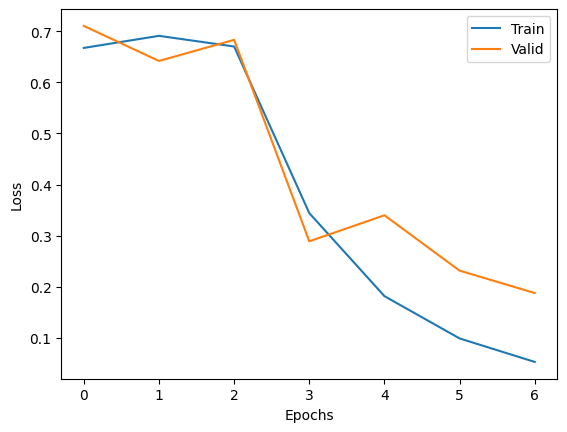

In [19]:
train_loss_list, valid_loss_list, epoch_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(epoch_list, train_loss_list, label='Train')
plt.plot(epoch_list, valid_loss_list, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from <== /content/drive/MyDrive/TASI/RandomSearch/ModelImbalance/model.pt
Classification Report:
Real - Precision: 0.8547, Recall: 0.9174, F1-Score: 0.8850
Fake - Precision: 0.9587, Recall: 0.9248, F1-Score: 0.9414
Accuracy: 0.9223880597014925


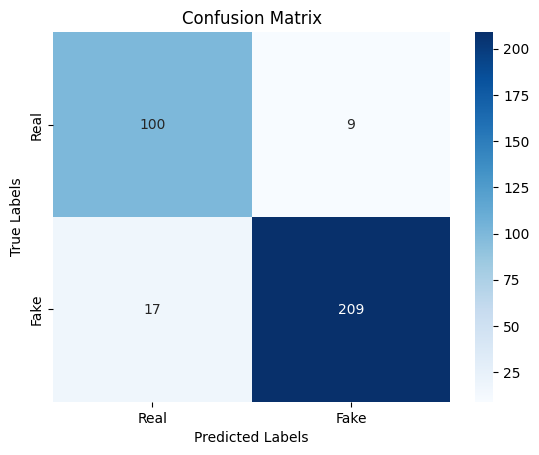

In [20]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text), _ in test_loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            output = model(text, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())

    # Mengganti label 1 menjadi "real" dan label 0 menjadi "fake"
    y_true = np.where(np.array(y_true) == 1, "real", "fake")
    y_pred = np.where(np.array(y_pred) == 1, "real", "fake")

    # Menghitung dan mencetak hasil precision, recall, f1-score, dan accuracy
    report = classification_report(y_true, y_pred, labels=["real", "fake"], digits=4, output_dict=True)
    print('Classification Report:')
    for label, scores in report.items():
        if label in ["real", "fake"]:
            precision = scores['precision']
            recall = scores['recall']
            f1_score = scores['f1-score']
            print(f"{label.capitalize()} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy}')

    # Menghitung dan mencetak confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Real', 'Fake'])
    ax.yaxis.set_ticklabels(['Real', 'Fake'])
    plt.show()

best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)